# Songs Popularity Prediction

## Obiettivo 
L'obiettivo di questo progetto è la creazione di un modello in grado di predire la popolarità di una canzone sulla base di alcuni suoi parametri, quali il genere, la durata e l'anno di uscita, e sulla base di alcuni parametri che riguardano l'artista che l'ha creata. 

## Dataset
Il dataset è stato reperito all'indirizzo https://www.kaggle.com/datasets/conorvaneden/best-songs-on-spotify-for-every-year-2000-2023 e contiene dati sulle 100 canzoni più popolari per ogni anno dal 2000 al 2023, per un totale di 2385 record.

## Implementazione

In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### Descrizione dataset

Carichiamo innanzitutto il dataset dal file .csv e mostriamone le prime righe.

In [18]:
songs = pd.read_csv("songs.csv", sep=";")
songs.head(10)

,title,artist,top genre,year,bpm,energy,danceability,dB,liveness,valence,duration,acousticness,speechiness,popularity
0,Flowers,Miley Cyrus,pop,2023,118,68,71,-4,3,65,200,6,7,98
1,Cupid - Twin Ver.,FIFTY FIFTY,k-pop girl group,2023,120,59,78,-8,35,73,174,44,3,97
2,BESO,ROSALÍA,pop,2023,95,64,77,-7,17,53,195,74,14,96
3,Boy's a liar Pt. 2,PinkPantheress,bronx drill,2023,133,81,70,-8,25,86,131,25,5,96
4,Creepin' (with The Weeknd & 21 Savage),Metro Boomin,rap,2022,98,62,72,-6,8,17,222,42,5,96
5,Daylight,David Kushner,gen z singer-songwriter,2023,130,43,51,-9,9,32,213,83,3,96
6,TQG,KAROL G,reggaeton,2023,180,63,72,-4,9,61,199,67,28,96
7,Calm Down (with Selena Gomez),Rema,afrobeats,2022,107,81,80,-5,11,80,239,38,4,95
8,Anti-Hero,Taylor Swift,pop,2022,97,64,64,-7,14,53,201,13,5,94
9,Here With Me,d4vd,bedroom pop,2022,132,47,57,-8,13,29,242,53,3,94


Si noti che i record del dataset sono già ordinati per popolarità decrescente.

Notare inoltre come sia stato usato un indice numerico generato automaticamente da pandas, poiché nessun insieme di attributi può costituire una chiave primaria in questo dataset: il titolo non può esserlo perché due canzoni diverse possono ovviamente condividere lo stesso titolo, ma anche la coppia (titolo, artista) non funziona in quanto una canzone può essere rilasciata più volte (in linea teorica anche durante lo stesso anno, per quanto molto improbabile, e quindi aggiungere l'anno non aiuta).

Questa è la descrizione del significato delle variabili data dal creatore del dataset:
- Genre - the genre of the track
- Year - the release year of the recording. Note that due to vagaries of releases, re-releases, re-issues and general madness, sometimes the release years are not what you'd expect.
- Added - the earliest date you added the track to your collection.
- Beats Per Minute (BPM) - The tempo of the song.
- Energy - The energy of a song - the higher the value, the more energtic. song
- Danceability - The higher the value, the easier it is to dance to this song.
- Loudness (dB) - The higher the value, the louder the song.
- Liveness - The higher the value, the more likely the song is a live recording.
- Valence - The higher the value, the more positive mood for the song.
- Length - The duration of the song.
- Acousticness - The higher the value the more acoustic the song is.
- Speechiness - The higher the value the more spoken word the song contains.
- Popularity - The higher the value the more popular the song is.
- Duration - The length of the song.

Si faccia riferimento all'indirizzo http://organizeyourmusic.playlistmachinery.com/ per maggiori informazioni.

Nel nome delle colonne *speechiness* e *danceability* è presente uno spazio di troppo, che va rimosso.

In [19]:
songs.columns = songs.columns.str.replace('speechiness ', 'speechiness').str.replace('danceability ', 'danceability')

### Integrazione del dataset con altre fonti

Si è ritenuto necessario aggiungere al dataset una colonna contenente i vari testi delle canzoni, il cui contenuto, opportunamente processato con tecniche di Natural Language Processing, può essere di grande aiuto per predire la popolarità di una canzone.
Si è dunque fatto uso della libreria *lyricsgenius*, che tramite l'API del sito https://genius.com/ permette di scaricare il testo di una canzone dato il titolo e l'autore.

Di seguito è possibile trovare il codice (commentato) che esegue questa operazione. Si noti tuttavia che può richiedere molto tempo (almeno un'ora) per essere eseguito, in quanto le richieste vanno spesso in timeout. Non è necessario eseguire le celle seguenti, in quanto i testi sono già stati scaricati e si trovano nel file *songs_lyrics.csv*. 

In [20]:
#%pip install lyricsgenius
#import lyricsgenius as lg

In [21]:
#import csv

#access_token = '8yvpmDv96aodI5vg660Afcby4XPdrhPrx4JCAM3souNcRYG9C2nF5TWg1'
#genius = lg.Genius(access_token)

#def get_lyrics(song_title, artist_name):
#    song = genius.search_song(song_title, artist_name)
#    return song.lyrics if song is not None else ""

#songs = pd.read_csv("songs.csv", sep=";")

#with open("songs_lyrics.csv", "a", newline="", encoding="utf-8") as csv_file:
#    writer = csv.writer(csv_file, delimiter="|")
#    writer.writerow(["title", "artist", "lyrics"])
#    for _, song in songs.iterrows():
#        is_ok = False
#        while not is_ok:
#           try:
#                lyrics = get_lyrics(song.title, song.artist)
#                is_ok = True
#                writer.writerow([song.title, song.artist, lyrics])
#            except Exception as e:
#                continue

Carichiamo e mostriamo il nuovo dataset contenente le _lyrics_ delle canzoni.

In [22]:
lyrics = pd.read_csv("songs_lyrics.csv", sep="|", na_values={"": None}, keep_default_na=False)
lyrics

,title,artist,lyrics
0,Flowers,Miley Cyrus,88 ContributorsTranslationsEspañolPortuguêsKis...
1,Cupid - Twin Ver.,FIFTY FIFTY,1 ContributorTranslationsEnglishBahasa MelayuF...
2,BESO,ROSALÍA,29 ContributorsTranslationsPortuguêsEnglishDeu...
3,Boy's a liar Pt. 2,PinkPantheress,92 ContributorsTranslationsPortuguêsTürkçeDeut...
4,Creepin' (with The Weeknd & 21 Savage),Metro Boomin,2 ContributorsNew Music Friday 12/02/22 Lyrics...
...,...,...,...
2380,Southbound,Beach Blvd,2 ContributorsMe & My Skate Lyrics[Skit]\r\nOh...
2381,Dance with Somebody - Radio Version,Mando Diao,1 ContributorDance With Somebody - Radio Versi...
2382,Flow,Desire Machines,1 ContributorWhat Matters? Lyrics[Hook]\r\nLea...
2383,Scared of the Dark,Everything Brighter,1 ContributorWay Home LyricsYa Ya Ya\r\n\r\nI ...


Per alcune canzoni, l'API di Genius non fornisce alcun testo.

In [23]:
lyrics[lyrics["lyrics"] == ''][:10]

,title,artist,lyrics
16,Until I Found You (with Em Beihold) - Em Beiho...,Stephen Sanchez,
317,"Happy - From ""Despicable Me 2""",Pharrell Williams,
339,"Moves Like Jagger - Studio Recording From ""The...",Maroon 5,
446,CAN'T STOP THE FEELING! (from DreamWorks Anima...,Justin Timberlake,
684,Valerie (feat. Amy Winehouse) - Version Revisited,Mark Ronson,
686,Waka Waka (This Time for Africa) [The Official...,Shakira,
905,Free Fallin' - Live at the Nokia Theatre Los A...,John Mayer,
912,Intro,The xx,
947,Summertime Sadness (Lana Del Rey Vs. Cedric Ge...,Lana Del Rey,
1086,Jenny from the Block (feat. Jadakiss & Styles ...,Jennifer Lopez,


In generale, i testi scaricati sono "sporchi", cioè contengono messaggi da parte dell'API che però non fanno parte del testo della canzone. 

In [24]:
lyrics["lyrics"][0]

"88 ContributorsTranslationsEspañolPortuguêsKiswahiliDeutschItalianoСрпскиNederlandsSvenskaPolskiTürkçeΕλληνικάFrançaisDanskРусскийالعربيةУкраїнськаBahasa IndonesiaFlowers Lyrics[Verse 1]\r\nWe were good, we were gold\r\nKinda dream that can't be sold\r\nWe were right 'til we weren't\r\nBuilt a home and watched it burn\r\n\r\n[Pre-Chorus]\r\nMm, I didn't wanna leave you, I didn't wanna lie\r\nStarted to cry, but then remembered I\r\n\r\n[Chorus]\r\nI can buy myself flowers\r\nWrite my name in the sand\r\nTalk to myself for hours\r\nSay things you don't understand\r\nI can take myself dancing\r\nAnd I can hold my own hand\r\nYeah, I can love me better than you can\r\n\r\n[Post-Chorus]\r\nCan love me better, I can love me better, baby\r\nCan love me better, I can love me better, baby\r\n\r\n[Verse 2]\r\nPaint my nails cherry-red\r\nMatch the roses that you left\r\nNo remorse, no regret\r\nI forgive every word you said\r\nYou might also like[Pre-Chorus]\r\nOoh, I didn't wanna leave you, b

Il codice seguente permette di effettuare la pulizia dei testi.

In [25]:
def clear_lyrics(text):
    return text.split("Lyrics")[1].split("Embed")[0] if text != '' and text.count(" - ") < 10 else ''

In [26]:
lyrics["lyrics"] = lyrics["lyrics"].map(clear_lyrics)
lyrics

,title,artist,lyrics
0,Flowers,Miley Cyrus,"[Verse 1]\r\nWe were good, we were gold\r\nKin..."
1,Cupid - Twin Ver.,FIFTY FIFTY,"[Intro: Aran]\r\nLa, la, la, la-la-la\r\nLa, l..."
2,BESO,ROSALÍA,"[Letra de ""BESO""]\r\n\r\n[Coro: ROSALÍA]\r\nYa..."
3,Boy's a liar Pt. 2,PinkPantheress,[Verse 1: PinkPantheress]\r\nTake a look insid...
4,Creepin' (with The Weeknd & 21 Savage),Metro Boomin,
...,...,...,...
2380,Southbound,Beach Blvd,"[Skit]\r\nOh shit God damn, I almost hit that ..."
2381,Dance with Somebody - Radio Version,Mando Diao,Break your happy home\r\nLearn to sing alone\r...
2382,Flow,Desire Machines,[Hook]\r\nLeave my home to chase what matters\...
2383,Scared of the Dark,Everything Brighter,Ya Ya Ya\r\n\r\nI hear stuff in my basement\r\...


### Analisi esplorativa

In [27]:
corr = songs.corr(numeric_only=True)
print(abs(corr["popularity"]).sort_values(ascending=False))

popularity      1.000000
year            0.205909
energy          0.120484
acousticness    0.100588
duration        0.095590
valence         0.086720
speechiness     0.072670
bpm             0.019961
danceability    0.019491
liveness        0.019009
dB              0.004715
Name: popularity, dtype: float64


Come si può vedere dagli indici di correlazione delle features rispetto alla label *popularity*, i decibel *dB* non influiscono in maniera significativa sulla popolarità, quindi la colonna può essere eliminata (in realtà forse conviene comunque tenerla perché le varie regolarizzazioni sistemano già questa cosa).

In [28]:
songs.drop(["dB"], axis=1, inplace=True)

In [29]:
songs_of_artist = songs.groupby("artist").count().aggregate("max", axis=1)
songs["songs of artist"] = songs["artist"].map(songs_of_artist)

Dividiamo il dataset in variabili testuali e numeriche per effettuare una ricerca corretta.

In [45]:
string_columns = songs.select_dtypes(include=["object"]).columns
numeric_columns = songs.select_dtypes(include=["number"]).columns

title


Dato che il dataset calcola la popolarità attuale, convertiamo l'anno di uscita come distanza dal 2023.

In [71]:
songs["year"] = 2023 - songs["year"]

Analizziamo le relazioni fra le variabili numeriche plottando una matrice di scatter

In [72]:
songs

,title,artist,top genre,year,bpm,energy,danceability,liveness,valence,duration,acousticness,speechiness,popularity,songs of artist,distance
0,Flowers,Miley Cyrus,pop,0,118,68,71,3,65,200,6,7,98,10,0
1,Cupid - Twin Ver.,FIFTY FIFTY,k-pop girl group,0,120,59,78,35,73,174,44,3,97,1,0
2,BESO,ROSALÍA,pop,0,95,64,77,17,53,195,74,14,96,2,0
3,Boy's a liar Pt. 2,PinkPantheress,bronx drill,0,133,81,70,25,86,131,25,5,96,1,0
4,Creepin' (with The Weeknd & 21 Savage),Metro Boomin,rap,1,98,62,72,8,17,222,42,5,96,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2380,Southbound,Beach Blvd,rock,0,140,88,60,10,49,228,19,4,21,1,0
2381,Dance with Somebody - Radio Version,Mando Diao,dalarna indie,14,150,90,55,36,51,241,0,9,16,1,14
2382,Flow,Desire Machines,indie,1,100,87,60,9,74,255,0,5,15,1,1
2383,Scared of the Dark,Everything Brighter,pop,0,120,80,65,7,61,179,0,6,11,1,0


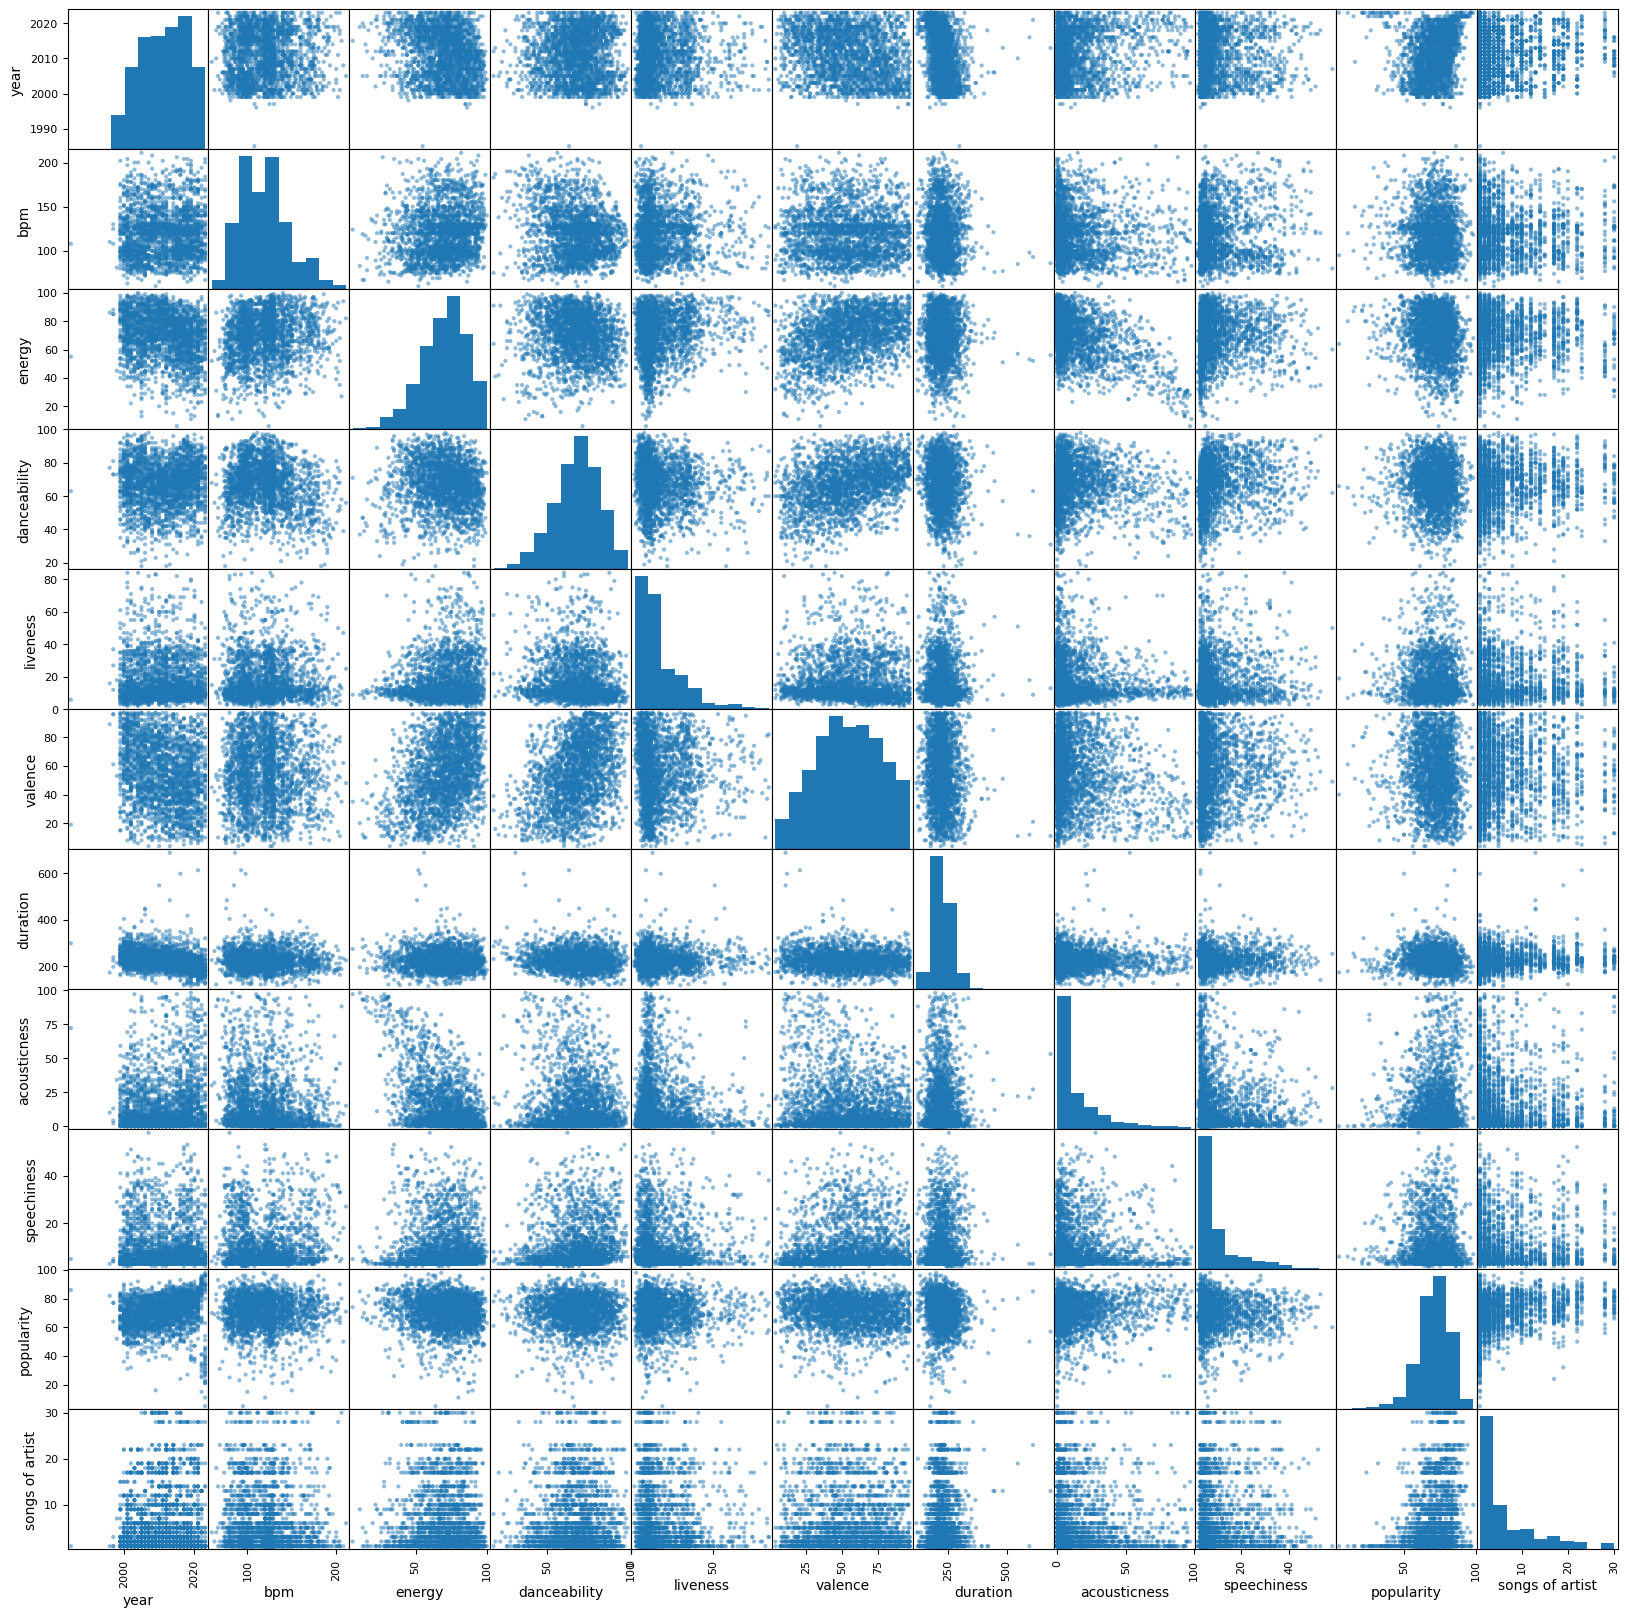

In [48]:
from pandas.plotting import scatter_matrix

scatter_matrix(songs[numeric_columns], figsize=(20, 20));